In [15]:
from pygt3x.reader import FileReader
from pygt3x.calibration import CalibratedReader
import pygt3x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [16]:
path = "C:\\Users\\u0117545\\KU Leuven\\An De Groef - DATA\\BC_002\\Accelerometrie\\"
ppID = 'T0\\'

dir_path = path + ppID

# list file and directories
res = os.listdir(dir_path)
res

['BC_002_H_T0.agd',
 'BC_002_H_T0.gt3x',
 'BC_002_H_T060sec.agd',
 'BC_002_H_T060secClinicalReport.pdf',
 'BC_002_L_T0.agd',
 'BC_002_L_T0.gt3x',
 'BC_002_R_T0.agd',
 'BC_002_R_T0.gt3x']

File to analyse: BC_002_H_T0.gt3x
Input path: C:\Users\u0117545\KU Leuven\An De Groef - DATA\BC_002\Accelerometrie\T0\BC_002_H_T0.gt3x
Output path: C:\Users\u0117545\KU Leuven\An De Groef - DATA\BC_002\Accelerometrie\T0\csv\BC_002_H_T0.csv
                     X         Y         Z
Timestamp                                 
1.651817e+09 -0.039062  0.855469 -0.585938
1.651817e+09 -0.046875  0.843750 -0.582031
1.651817e+09 -0.054688  0.839844 -0.578125
1.651817e+09 -0.054688  0.839844 -0.582031
1.651817e+09 -0.046875  0.843750 -0.578125
________________________________________________________________________________

File to analyse: BC_002_L_T0.gt3x
Input path: C:\Users\u0117545\KU Leuven\An De Groef - DATA\BC_002\Accelerometrie\T0\BC_002_L_T0.gt3x
Output path: C:\Users\u0117545\KU Leuven\An De Groef - DATA\BC_002\Accelerometrie\T0\csv\BC_002_L_T0.csv
                     X         Y         Z
Timestamp                                 
1.651817e+09  0.003906 -0.214844 -0.964844
1.651817

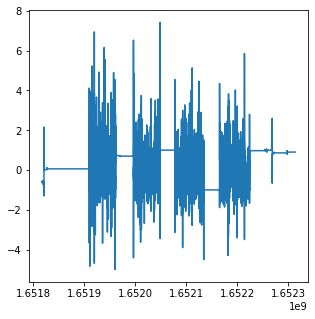

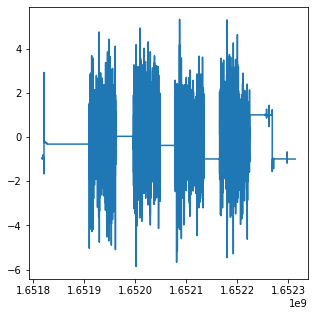

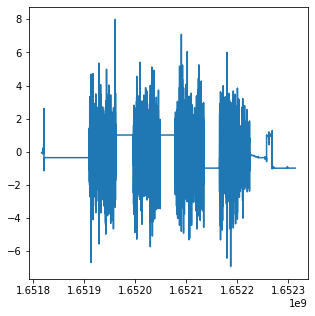

In [17]:
for file in os.listdir(dir_path):
    if '.gt3x' in file:
        print(bcolors.HEADER  + 'File to analyse: {}'.format(file) + bcolors.ENDC)
        Input = file
        core = Input[:Input.find('.')]
        input_path = dir_path + Input
        output_path = dir_path + "csv\\" + core + '.csv'
        
        print('Input path: {}'.format(input_path))
        print('Output path: {}'.format(output_path))
        
        with FileReader(input_path) as reader:
            calibrated_reader = CalibratedReader(reader)
            df = calibrated_reader.to_pandas()
            print(df.head())
            #df.to_csv(output_path)
            
           
        data = df.iloc[:,0:].values
            
            
        ncols = 1
        nrows = 2
        f = plt.figure(figsize=(5, 5))
        plt.subplots_adjust(hspace=0.25)
        plt.plot(df['Z'])
        
        print(80*'_'+'\n')

In [18]:
# return the non-wear_time using hees' function
hz = 30 
min_non_wear_time_window = 135
window_overlap = 1 
std_mg_threshold = 3.0
std_min_num_axes = 2
value_range_mg_threshold = 50.0
value_range_min_num_axes = 2
    
# number of data samples in 1 minute
num_samples_per_min = hz * 60

# define the correct number of samples for the window and window overlap
min_non_wear_time_window *= num_samples_per_min
window_overlap *= num_samples_per_min


# convert the standard deviation threshold from mg to g
std_mg_threshold /= 1000

# convert the value range threshold from mg to g
value_range_mg_threshold /= 1000

# new array to record non-wear time. Convention is 0 = non-wear time, and 1 = wear time. Since we create a new array filled with ones, we only have to 
# deal with non-wear time (0), since everything else is already encoded as wear-time (1)
non_wear_vector = np.ones((data.shape[0], 1), dtype = 'uint8')

# loop over the data, start from the beginning with a step size of window overlap
for i in range(0, len(data), window_overlap):


    # define the start of the sequence
    start = i

    # define the end of the sequence
    end = i + min_non_wear_time_window

    # slice the data from start to end
    subset_data = data[start:end]

    # check if the data sequence has been exhausted, meaning that there are no full windows left in the data sequence (this happens at the end of the sequence)
    # comment out if you want to use all the data
    if len(subset_data) < min_non_wear_time_window:
        break


    # calculate the standard deviation of each column (YXZ)
    std = np.std(subset_data, axis=0)

    # check if the standard deviation is below the threshold, and if the number of axes the standard deviation is below equals the std_min_num_axes threshold

    if (std < std_mg_threshold).sum() >= std_min_num_axes:


        # at least 'std_min_num_axes' are below the standard deviation threshold of 'std_min_num_axes', now set this subset of the data to 0 which will 
        # record it as non-wear time. Note that the full 'new_wear_vector' is pre-populated with all ones, so we only have to set the non-wear time to zero
        non_wear_vector[start:end] = 0

    # calculate the value range (difference between the min and max) (here the point-to-point numpy method is used) for each column
    value_range = np.ptp(subset_data, axis = 0)

    # check if the value range, for at least 'value_range_min_num_axes' (e.g. 2) out of three axes, was less than 'value_range_mg_threshold' (e.g. 50) mg

    if (value_range < value_range_mg_threshold).sum() >= value_range_min_num_axes:
        # set the non wear vector to non-wear time for the start to end slice of the data
        # Note that the full array starts with all ones, we only have to set the non-wear time to zero
        non_wear_vector[start:end] = 0
   

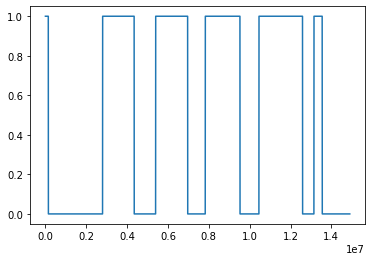

In [19]:
plt.plot(non_wear_vector)

In [20]:
min_non_wear_time_window

243000

In [21]:
min_non_wear_time_window

243000

In [25]:
import gt3x



actigraph_acc, actigraph_time, meta_data = gt3x.read_gt3x("C:\\Users\\u0117545\\KU Leuven\\An De Groef - DATA\\BC_002\\Accelerometrie\\T0\\BC_002_H_T0.gt3x")

ValueError: cannot convert float NaN to integer